# MUSIC ANALYSIS USING SPOTIFY API


In [3]:
#IMPORTING LIBRARIES


import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import csv
import time
import json
import sys
import imp
imp.reload(sys)
%matplotlib inline
sns.set_style("whitegrid")
import warnings 
warnings.filterwarnings("ignore")


# Getting Access Token for Spotify API

In [11]:
import requests
import json
client_id = 'f53766086llc46d5a9042c8fb26be2e2'
client_secret = '2d334ae2a25a49df87c6ad492fkk4c01'

grant_type = 'client_credentials'

#Request based on Client Credentials Flow from https://developer.spotify.com/web-api/authorization-guide/

#Request body parameter: grant_type Value: Required. Set it to client_credentials
body_params = {'grant_type' : grant_type}

url='https://accounts.spotify.com/api/token'

response=requests.post(url, data=body_params, auth = (client_id, client_secret)) 
response.text

'{"access_token":"BQDsE0i32HkpcUjkS0J3IvOjjcyGoJ6rhYNBaPikiTaWM4ubDnrH3ZLZRX0lqWKiV5GmG2ylaDOgDwJqUF0","token_type":"Bearer","expires_in":3600,"scope":""}'

In [12]:
access_token = (  'Bearer BQDsE0i32HkpcUjkS0IXhhmvOcyGoJ6rhYNBaPikiTaWM4ubDnrH3ZLZRX0lqWKiV5GmG2ylaDOgDwJqUF0')

# MAIN FUNCTION 

In [25]:


def main():
    
    queries = ['1995','1996','1997','1998','1999','2000','2001',
             '2002','2003','2004','2005','2006','2007','2008',
             '2009','2010','2011','2012','2013','2014','2015','2016','2017']
              
    
    # Query and request from API are different!
    # Number of track query need to make
    num_tracks_per_query = 10000

    for query in queries:
        
        ltrack = []
        song_ids = []
        artist_ids = []
        album_ids = []
        
        audioF = []
        artist_data = []
        album_data = []

        
        col1 = [   'popularity',
                   'song_id',     'artist_id',     'album_id', 
                   'song_name',   'artist_name',   'album_name', 
                   'explicit',    'disc_number',   'track_number']
        
        
        col2 =  [  'song_id', 'uri',
                   'tempo', 'type',
                   'key', 'loudness',
                   'mode', 'speechiness',
                   'liveness', 'valence',
                   'danceability', 'energy',
                   'track_href', 'analysis_url',
                   'duration_ms', 'time_signature',
                   'acousticness', 'instrumentalness' ]
        
        col3 =  [  'artist_id',  'artist_genres',  'artist_popularity']
        
        col4 =  [  'album_id',  'album_genres',   'album_popularity',  'album_release_date']
        
        n = 0 
        idx = 0
        
        while idx < num_tracks_per_query:  
            
            API_search_request(query, 'track', 50, idx, ltrack, song_ids, artist_ids, album_ids)   
            n +=1
            # print(('\n>> this is No '+ str(n) + ' search End '))
            idx += 50 
            # Limit API requests to at most 3ish calls / second
            time.sleep(0.3)                                     
        
        print(len(song_ids))
        ## spotify API "search" option vs here track/audiofeature query
        for idx in range(0, len(song_ids), 50):
            API_get_audio_feature(song_ids[idx: idx+50], audioF)
            time.sleep(0.3)
        
        for idx in range(0, len(artist_ids), 50):
            API_get_artists(artist_ids[idx: idx+50], artist_data)
            time.sleep(0.3)
        
        for idx in range(0, len(album_ids), 20):
            API_get_albums(album_ids[idx: idx+20], album_data)
            time.sleep(0.3)    
        
        
        df1 = pd.DataFrame(ltrack, columns=col1)
        
        df2 = pd.DataFrame(audioF, columns=col2) 
        
        
        df3 = pd.DataFrame(artist_data, columns=col3)
        
        df4 = pd.DataFrame(album_data, columns=col4)
        
        df = df1.merge(df2, on='song_id', how='outer').merge(df3, on='artist_id', how='outer').merge(
             df4, on='album_id', how='outer')
        
        filename = query + '.csv'                      
        print(filename)
        df.to_csv(filename, sep='\t')
        
        print ('finish')
        print (query)
        

# API_Search_request 

In [18]:
def API_search_request(keywords, search_type, results_limit, results_offset, ltrack, song_ids, artist_ids, album_ids):

    off = str(results_offset)
    lim = str(results_limit)
    
    url = 'https://api.spotify.com/v1/search?q=year:'+ keywords +'&type=' + search_type +'&offset='+ off +'&limit=' + lim
    
    r = requests.get(url, headers={"Accept": "application/json" , "Authorization": access_token})
    

    if r: 
       j = r.json()
    else:
      return r


    litem = j['tracks']['items']
    #print(len(ll))
    try:
        for l in litem:
        
            if l['id'] not in song_ids:
                song_ids.append( l['id'] )

            if l['artists'][0]['id'] not in artist_ids:
                artist_ids.append( l['artists'][0]['id'] )

            if l['album']['id'] not in album_ids:
                album_ids.append(  l['album']['id'] )
        
        
            k =   [  l['popularity'],
        
                     l['id'], 
                     l['artists'][0]['id'],
                     l['album']['id'],

                     l['name'],
                     l['artists'][0]['name'],
                     l['album']['name'],

                     l['explicit'], 
                     l['disc_number'],
                     l['track_number']]
        
            ltrack.append(k)
    except:
         ValueError
      
   # f.close()
    #return j


# API_get_audio_feature

In [19]:
def API_get_audio_feature(songids, audioF):
    
    #print(songids)
    #print '>> call art several'
    track_ids = ','.join(songids)

    url = 'https://api.spotify.com/v1/audio-features?ids=' + track_ids  
    ## access_token will expire soon    
    
    r = requests.get(url, headers={"Accept": "application/json" , "Authorization": access_token})
    
    if r: 
      j = r.json()
    else:
      return r
    
    # print(j)
    ll = j['audio_features']

    try:

        for l in ll:
            k =  [  l['id'],l['uri'],
                    l['tempo'],l['type'],
                    l['key'],l['loudness'],
                    l['mode'],l['speechiness'],
                    l['liveness'],l['valence'],
                    l['danceability'],l['energy'],
                    l['track_href'],l['analysis_url'],
                    l['duration_ms'],l['time_signature'],
                    l['acousticness'],l['instrumentalness'] ]

            audioF.append(k)
        
    except:
        ValueError
    
        

    #return j

# API_get_artists

In [20]:
def API_get_artists(artist_ids, artist_data):

    art_ids = ','.join(artist_ids)

    url = 'https://api.spotify.com/v1/artists?ids=' + art_ids
    
    r = requests.get(url, headers={"Accept": "application/json" , "Authorization": access_token})
    

    if r:
       j = r.json()
    else:
       #print 'for this specific art_ids, response reaches maximum, return'
       return r

    
    ll = j['artists']

    try:
        for l in ll:
        
            k = [  l['id'], 
                   l['genres'],
                   l['popularity'] ]

            artist_data.append(k)
    
    except:
        ValueError

# API_get_albums

In [21]:


def API_get_albums(album_ids, album_data):
   

    alb_ids = ','.join(album_ids)

    url = 'https://api.spotify.com/v1/albums?ids=' + alb_ids
    
    r = requests.get(url, headers={"Accept": "application/json" , "Authorization": access_token})
    

    if r:
       j = r.json()
    else:
       return r


    ll = j['albums']
    
    try:
        for l in ll:
            k = [  l['id'], 
                   l['genres'],
                   l['popularity'],
                   l['release_date'] ]

            album_data.append(k)
    
    except:
        ValueError



 

In [26]:
main()

2000
2013.csv
finish
2013


In [83]:
dataset1 = pd.read_csv('1999.csv',sep='\t')
dataset2 = pd.read_csv('2000.csv',sep='\t')
dataset3 = pd.read_csv('2001.csv',sep='\t')
dataset4 = pd.read_csv('2002.csv',sep='\t')
dataset5 = pd.read_csv('2003.csv',sep='\t')
dataset6 = pd.read_csv('2004.csv',sep='\t')
dataset7 = pd.read_csv('2005.csv',sep='\t')
dataset8 = pd.read_csv('2006.csv',sep='\t')
dataset9 = pd.read_csv('2007.csv',sep='\t')
dataset10 = pd.read_csv('2008.csv',sep='\t')
dataset11 = pd.read_csv('2009.csv',sep='\t')
dataset12 = pd.read_csv('2010.csv',sep='\t')
dataset13 = pd.read_csv('2011.csv',sep='\t')
dataset14 = pd.read_csv('2012.csv',sep='\t')
dataset15 = pd.read_csv('2013.csv',sep='\t')
dataset16 = pd.read_csv('2014.csv',sep='\t')
dataset17 = pd.read_csv('2015.csv',sep='\t')
dataset18 = pd.read_csv('2016.csv',sep='\t')
dataset19 = pd.read_csv('2017.csv',sep='\t')
dataset20 = pd.read_csv('2018.csv',sep='\t')
dataset21 = pd.read_csv('2019.csv',sep='\t')
dataset=dataset1.append(
        dataset2.append(
        dataset3.append(
        dataset4.append(
        dataset5.append(
        dataset6.append(
        dataset7.append(
        dataset8.append(
        dataset9.append(
        dataset10.append(
        dataset11.append(
        dataset12.append(
        dataset13.append(
        dataset14.append(
        dataset15.append(
        dataset16.append(
        dataset17.append(
        dataset18.append(
        dataset19.append(
        dataset20.append(
        dataset21))))))))))))))))))))

In [84]:
dataset.head()

,Unnamed: 0,popularity,song_id,artist_id,album_id,song_name,artist_name,album_name,explicit,disc_number,...,analysis_url,duration_ms,time_signature,acousticness,instrumentalness,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
0,0,79,1KGi9sZVMeszgZOWivFpxs,0TImkz4nPqjegtVSMZnMRq,1CvjjpvqVMoyprsf74bpYW,No Scrubs,TLC,Fanmail,False,1,...,https://api.spotify.com/v1/audio-analysis/1KGi...,214400.0,4.0,0.02510,0.000717,"['atl hip hop', 'dance pop', 'girl group', 'hi...",72.0,[],74.0,1999-02-23
1,1,63,0BUoLE4o9eVahDHvTqak67,0TImkz4nPqjegtVSMZnMRq,1CvjjpvqVMoyprsf74bpYW,Unpretty,TLC,Fanmail,False,1,...,https://api.spotify.com/v1/audio-analysis/0BUo...,278067.0,4.0,0.00152,0.000060,"['atl hip hop', 'dance pop', 'girl group', 'hi...",72.0,[],74.0,1999-02-23
2,2,42,79Dduf9L3DBCsmqgv5feXO,0TImkz4nPqjegtVSMZnMRq,04LFXnEBkVE6mZfxGeCLbM,Silly Ho,TLC,Fanmail,False,1,...,https://api.spotify.com/v1/audio-analysis/79Dd...,255160.0,3.0,0.03870,0.471000,"['atl hip hop', 'dance pop', 'girl group', 'hi...",72.0,[],51.0,1999-02-23
3,3,46,3NpsJc5SOINskuK3z08Q9C,0TImkz4nPqjegtVSMZnMRq,04LFXnEBkVE6mZfxGeCLbM,No Scrubs,TLC,Fanmail,False,1,...,https://api.spotify.com/v1/audio-analysis/3Nps...,214440.0,4.0,0.02500,0.000666,"['atl hip hop', 'dance pop', 'girl group', 'hi...",72.0,[],51.0,1999-02-23
4,4,38,3mdsDgWOkTDOUWboBAMIxI,0TImkz4nPqjegtVSMZnMRq,04LFXnEBkVE6mZfxGeCLbM,I'm Good at Being Bad,TLC,Fanmail,True,1,...,https://api.spotify.com/v1/audio-analysis/3mds...,277693.0,4.0,0.24200,0.000000,"['atl hip hop', 'dance pop', 'girl group', 'hi...",72.0,[],51.0,1999-02-23


In [85]:
dataset.drop(dataset.columns[[0]], axis = 1, inplace = True)

In [86]:
dataset.describe()

,popularity,disc_number,track_number,tempo,key,loudness,mode,speechiness,liveness,valence,danceability,energy,duration_ms,time_signature,acousticness,instrumentalness,artist_popularity,album_popularity
count,42000.000000,42000.000000,42000.000000,41976.000000,41976.000000,41976.000000,41976.000000,41976.000000,41976.000000,41976.000000,41976.000000,41976.000000,4.197600e+04,41976.000000,41976.000000,41976.000000,40506.000000,40000.000000
mean,53.881405,1.020548,5.805810,120.986904,5.241686,-7.457222,0.669359,0.093715,0.191935,0.497844,0.585731,0.642213,2.332135e+05,3.911950,0.263518,0.078753,69.665975,60.427525
std,10.098060,0.170105,5.465463,30.902922,3.570474,4.552629,0.470450,0.102513,0.160009,0.252953,0.173849,0.229517,9.359360e+04,0.411698,0.296472,0.228054,13.825983,11.778973
min,32.000000,1.000000,1.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.030100e+04,0.000000,0.000000,0.000000,0.000000,28.000000
25%,46.000000,1.000000,2.000000,96.035750,2.000000,-8.637250,0.000000,0.035100,0.095400,0.297000,0.476000,0.497000,1.933190e+05,4.000000,0.019800,0.000000,61.000000,52.000000
50%,53.000000,1.000000,4.000000,119.936000,5.000000,-6.360000,1.000000,0.049800,0.126000,0.493000,0.596000,0.674000,2.241600e+05,4.000000,0.132000,0.000004,70.000000,60.000000
75%,61.000000,1.000000,8.000000,141.060500,8.000000,-4.789750,1.000000,0.102000,0.243000,0.699000,0.713000,0.826000,2.599332e+05,4.000000,0.443000,0.001400,80.000000,69.000000
max,95.000000,7.000000,155.000000,232.690000,11.000000,1.342000,1.000000,0.950000,1.000000,1.000000,0.986000,1.000000,5.403500e+06,5.000000,0.996000,1.000000,100.000000,96.000000


In [87]:
dataset.corr()

,popularity,explicit,disc_number,track_number,tempo,key,loudness,mode,speechiness,liveness,valence,danceability,energy,duration_ms,time_signature,acousticness,instrumentalness,artist_popularity,album_popularity
popularity,1.000000,0.132141,-0.043104,-0.104789,-0.007355,-0.009301,0.058713,-0.059074,0.022056,-0.051635,-0.059349,0.132658,-0.032561,-0.090168,0.024919,-0.017686,-0.075818,0.416509,0.627677
explicit,0.132141,1.000000,-0.026704,0.040586,-0.017976,0.002677,0.122242,-0.108435,0.488418,0.059329,-0.013790,0.267916,0.079955,-0.029398,0.072317,-0.154218,-0.145203,0.240681,0.185342
disc_number,-0.043104,-0.026704,1.000000,0.028058,-0.014432,0.004566,-0.045548,0.007245,-0.014228,0.032016,0.009775,-0.014973,-0.035090,0.018719,-0.010547,0.038087,0.004449,0.031916,0.007948
track_number,-0.104789,0.040586,0.028058,1.000000,-0.030591,-0.001806,-0.109430,0.006621,0.029374,0.014770,-0.048793,-0.049846,-0.101693,0.014543,-0.020130,0.092277,0.046436,0.086420,0.145036
tempo,-0.007355,-0.017976,-0.014432,-0.030591,1.000000,0.003204,0.198281,0.019293,0.030751,0.004130,0.082265,-0.091115,0.201744,-0.029980,0.045015,-0.152234,-0.107955,0.017324,0.006111
key,-0.009301,0.002677,0.004566,-0.001806,0.003204,1.000000,0.033669,-0.131883,0.019504,-0.001197,0.047453,0.022038,0.036274,-0.002408,0.012695,-0.018329,-0.023062,0.001462,-0.009496
loudness,0.058713,0.122242,-0.045548,-0.109430,0.198281,0.033669,1.000000,-0.038560,0.089862,0.078410,0.339146,0.292516,0.746788,-0.057818,0.194560,-0.597238,-0.537900,0.150155,0.069675
mode,-0.059074,-0.108435,0.007245,0.006621,0.019293,-0.131883,-0.038560,1.000000,-0.106429,-0.018533,-0.003372,-0.068938,-0.069801,-0.025540,-0.031495,0.076805,-0.015198,-0.074727,-0.060058
speechiness,0.022056,0.488418,-0.014228,0.029374,0.030751,0.019504,0.089862,-0.106429,1.000000,0.136784,0.078644,0.205283,0.132635,-0.018279,0.054407,-0.110271,-0.131627,0.115884,0.074796
liveness,-0.051635,0.059329,0.032016,0.014770,0.004130,-0.001197,0.078410,-0.018533,0.136784,1.000000,-0.001976,-0.096279,0.178879,0.034640,-0.003778,-0.093607,-0.033303,0.005021,-0.003857


Text(0.5, 1.0, 'Popularity Distribution')

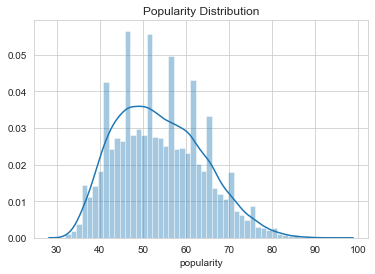

In [88]:
sns.distplot(dataset['popularity']).set_title('Popularity Distribution')


Text(0.5, 1.0, 'Popularity Based on Key')

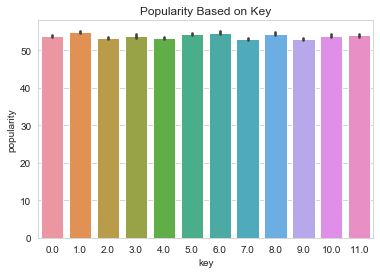

In [89]:
sns.barplot(x = 'key', y = 'popularity', data = dataset)
plt.title('Popularity Based on Key')

Text(0.5, 1, 'Popularity Based on Key')

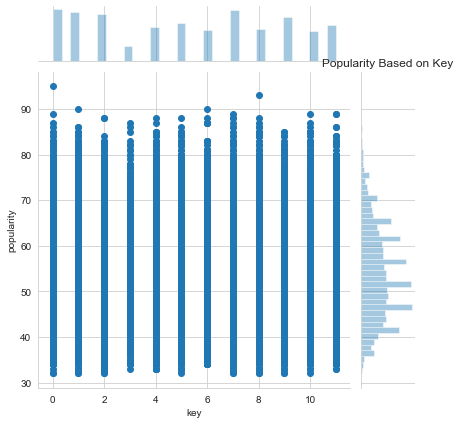

In [90]:
sns.jointplot(x = 'key', y = 'popularity', data = dataset)
plt.title('Popularity Based on Key')

Text(0.5, 1.0, 'Popularity Based on Mode')

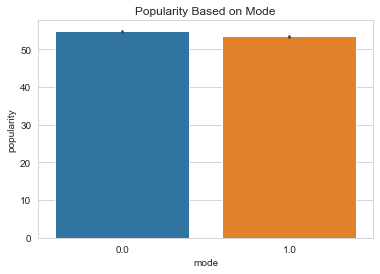

In [91]:
sns.barplot(x = 'mode', y = 'popularity', data = dataset)
plt.title('Popularity Based on Mode')

Text(0.5, 1.0, 'Popularity Based on Mode and Key')

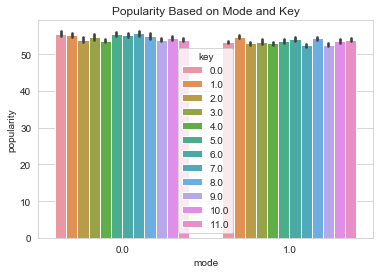

In [92]:
sns.barplot(x = 'mode', y = 'popularity', hue = 'key', data = dataset)
plt.title('Popularity Based on Mode and Key')

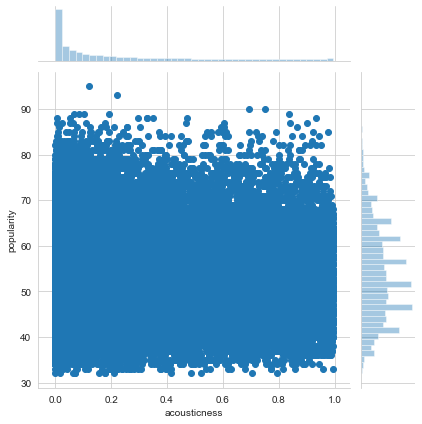

In [93]:
sns.jointplot(x = 'acousticness', y = 'popularity', data = dataset)

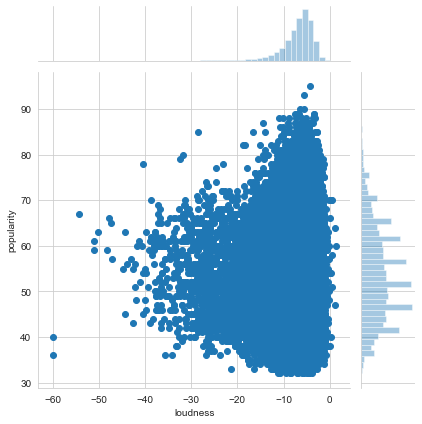

In [94]:
sns.jointplot(x = 'loudness', y = 'popularity', data = dataset)

In [95]:
dataset=dataset.dropna()

Text(0.5, 1.0, 'Acoustiness for Songs with More than 50 Popularity')

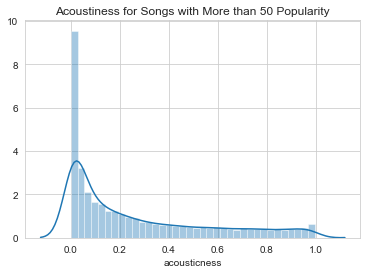

In [96]:
popular_above_50 = dataset[dataset.popularity > 50]
sns.distplot(popular_above_50['acousticness'])
plt.title('Acoustiness for Songs with More than 50 Popularity')

Text(0.5, 1.0, 'Loudness for Songs with More than 50 Popularity')

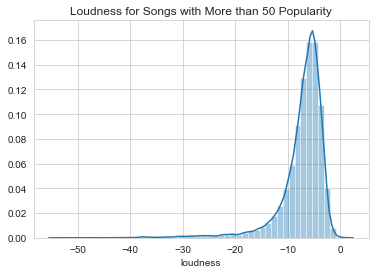

In [97]:
sns.distplot(popular_above_50['loudness'])
plt.title('Loudness for Songs with More than 50 Popularity')

# Feature Engineering

In [98]:
list_of_keys = dataset['key'].unique()
for i in range(len(list_of_keys)):
    dataset.loc[dataset['key'] == list_of_keys[i], 'key'] = i
dataset.sample(5)

,popularity,song_id,artist_id,album_id,song_name,artist_name,album_name,explicit,disc_number,track_number,...,analysis_url,duration_ms,time_signature,acousticness,instrumentalness,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
66,47,5eLovQzx9cm6RkQq388JyN,0z4gvV4rjIZ9wHck67ucSV,1cyN1SDx8uo2lBzelYG3qb,Smack That,Akon,Konvicted,True,1,3,...,https://api.spotify.com/v1/audio-analysis/5eLo...,212360.0,4.0,0.3210,0.000000,['dance pop'],83.0,[],66.0,2006
256,52,23Cr3klTV6cX5zuv8AySyI,3YcBF2ttyueytpXtEzn1Za,1rQZbncicoXyB64DqoH7OY,11 am,Incubus,Morning View,False,1,5,...,https://api.spotify.com/v1/audio-analysis/23Cr...,253427.0,4.0,0.0486,0.577000,"['alternative metal', 'alternative rock', 'fun...",73.0,[],70.0,2001-10-23
792,51,38jXCpkXh5h6rfrTmNNADe,3CAhiUHkUYT1mFtVHM9SHA,0k0b9mpJt6tJMT26aIzpoe,Cómo Me Duele,Valentín Elizalde,Vencedor,False,1,3,...,https://api.spotify.com/v1/audio-analysis/38jX...,219493.0,4.0,0.4690,0.000057,"['banda', 'grupera', 'norteno', 'ranchera', 'r...",73.0,[],67.0,2006-01-01
798,75,70YPzqSEwJvAIQ6nMs1cjY,45eNHdiiabvmbp4erw26rg,60xcVwuQJAOyu11xf9mObS,In Your Arms (with X Ambassadors),ILLENIUM,ASCEND,False,1,14,...,https://api.spotify.com/v1/audio-analysis/70YP...,220730.0,4.0,0.1980,0.000000,"['edm', 'electropop', 'melodic dubstep', 'pop'...",80.0,[],76.0,2019-08-16
651,46,5cXdB92xagJr4b30GjRbfX,7wCjDgV6nqBsHguQXPAaIM,3DDUesugWE5mJjTF5HFsRg,I'm a Ramblin' Man,Waylon Jennings,Nashville Rebel,False,2,18,...,https://api.spotify.com/v1/audio-analysis/5cXd...,166933.0,4.0,0.3070,0.002590,"['country', 'country rock', 'outlaw country', ...",72.0,[],65.0,2006-09-26


In [100]:
dataset.loc[dataset["mode"] == 'Major', "mode"] = 1
dataset.loc[dataset["mode"] == 'Minor', "mode"] = 0
dataset.sample(5)

,popularity,song_id,artist_id,album_id,song_name,artist_name,album_name,explicit,disc_number,track_number,...,analysis_url,duration_ms,time_signature,acousticness,instrumentalness,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
1033,44,3gsTFJT4018KkC4QL6NvGo,2nrSPPSfNesng85eRV4W4m,0Unjdke7MtUvhko4pos0uG,Deja De Llorar Chiquilla,Los Terricolas,Los Exitos de Los Terricolas,False,1,1,...,https://api.spotify.com/v1/audio-analysis/3gsT...,220520.0,4.0,0.7850,0.000000,"['bolero', 'grupera', 'pop romantico', 'ranche...",61.0,[],59.0,2002-08-20
1500,44,5zVjs89nsOIT7I90ETawau,46Unp6DY3Zmy7QS1Fx47yq,1mHCzqO6vjOdtwLZbWC4N6,Send Me the Pillow You Dream On,Hank Locklin,RCA Country Legends,False,1,4,...,https://api.spotify.com/v1/audio-analysis/5zVj...,147440.0,4.0,0.8400,0.000004,['nashville sound'],45.0,[],48.0,2003-03-03
1070,52,58d89y3a79GyRkKOff6cjP,5bSfBBCxY8QAk4Pifveisz,32OdNOo5ASvpnCZAMoxO6I,El Tarasco,La Arrolladora Banda El Limón De Rene Camacho,Nuestra Historia,False,1,19,...,https://api.spotify.com/v1/audio-analysis/58d8...,191053.0,4.0,0.6600,0.000002,"['banda', 'grupera', 'norteno', 'regional mexi...",79.0,[],51.0,2003-10-06
359,73,4PkIDTPGedm0enzdvilLNd,0X2BH1fck6amBIoJhDVmmJ,5AXNN75OmMjFrwst6ExNPx,Sixteen,Ellie Goulding,Sixteen,False,1,1,...,https://api.spotify.com/v1/audio-analysis/4PkI...,201072.0,4.0,0.2680,0.000000,"['dance pop', 'indietronica', 'metropopolis', ...",84.0,[],68.0,2019-04-12
1450,70,6JjPBQfI2Y8nIjnm65X6Pw,1SupJlEpv7RS2tPNRaHViT,5VQfOfiYcDLGZo9HFW1IJM,X (feat. Maluma & Ozuna) - Remix,Nicky Jam,X (feat. Maluma & Ozuna) [Remix],False,1,1,...,https://api.spotify.com/v1/audio-analysis/6JjP...,235747.0,4.0,0.0561,0.000038,"['latin', 'latin hip hop', 'reggaeton', 'tropi...",89.0,[],65.0,2018-06-29


In [101]:
list_of_time_signatures = dataset['time_signature'].unique()
for i in range(len(list_of_time_signatures)):
    dataset.loc[dataset['time_signature'] == list_of_time_signatures[i], 'time_signature'] = i
dataset.sample(5)

,popularity,song_id,artist_id,album_id,song_name,artist_name,album_name,explicit,disc_number,track_number,...,analysis_url,duration_ms,time_signature,acousticness,instrumentalness,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
688,68,5UShsJdqJLZkl5JNj1ITlP,3FCYSWNVmpjTCiwzJwbMAC,44UalHDV47RqefSRB8Xvz7,DRUGS,lil aaron,GLOING PAIN$,True,1,4,...,https://api.spotify.com/v1/audio-analysis/5USh...,116413.0,4.0,0.000715,0.000000,"['emo rap', 'glitchcore', 'pop rap', 'undergro...",62.0,[],63.0,2016-10-31
923,69,7iv32XEy2HlM7PqQO4lp5f,5qa31A9HySw3T7MKWI9bGg,4aGGhfTv8mJ9JAiz8dsa0L,All Love,FLETCHER,you ruined new york city for me,True,1,3,...,https://api.spotify.com/v1/audio-analysis/7iv3...,193600.0,4.0,0.272000,0.000261,"['dance pop', 'electropop', 'indie poptimism',...",75.0,[],72.0,2019-08-16
695,53,3lqT89gv8p3PYwXtr3ODjv,6I6t21SFbxZ7RbQgD5dN7U,5fjNNSyiwXoOQMCW4dLjJ2,I Wish,Carl Thomas,Emotional,False,1,3,...,https://api.spotify.com/v1/audio-analysis/3lqT...,226760.0,4.0,0.059300,0.000038,"['dance pop', 'hip pop', 'neo soul', 'new jack...",54.0,[],56.0,2000-04-18
1104,71,1RXXLvEKXmz2c6TG1EDUz2,3zG3fwEK20npYHIYooztq9,0XYTjI6bP5Wh1bLsUIRBtW,Calm Pour,Microdynamic Recordings,Misty Rain,False,1,3,...,https://api.spotify.com/v1/audio-analysis/1RXX...,143583.0,4.0,0.092600,0.982000,['sound'],61.0,[],67.0,2019-10-07
1359,51,03EsYwfN3RbDhU1kVrfffA,4eNW2w49yCMLXeOwAOWF9b,79XjqMCEOc1VJzgQCipw5F,On The Run,The Jompson Brothers,The Jompson Brothers,False,1,5,...,https://api.spotify.com/v1/audio-analysis/03Es...,296667.0,4.0,0.102000,0.297000,['modern southern rock'],46.0,[],53.0,2010-11-30


In [102]:
dataset.loc[dataset['popularity'] < 61, 'popularity'] = 0 
dataset.loc[dataset['popularity'] >= 61, 'popularity'] = 1
dataset.loc[dataset['popularity'] == 1]

,popularity,song_id,artist_id,album_id,song_name,artist_name,album_name,explicit,disc_number,track_number,...,analysis_url,duration_ms,time_signature,acousticness,instrumentalness,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
0,1,1KGi9sZVMeszgZOWivFpxs,0TImkz4nPqjegtVSMZnMRq,1CvjjpvqVMoyprsf74bpYW,No Scrubs,TLC,Fanmail,False,1,5,...,https://api.spotify.com/v1/audio-analysis/1KGi...,214400.0,4.0,0.025100,0.000717,"['atl hip hop', 'dance pop', 'girl group', 'hi...",72.0,[],74.0,1999-02-23
1,1,0BUoLE4o9eVahDHvTqak67,0TImkz4nPqjegtVSMZnMRq,1CvjjpvqVMoyprsf74bpYW,Unpretty,TLC,Fanmail,False,1,9,...,https://api.spotify.com/v1/audio-analysis/0BUo...,278067.0,4.0,0.001520,0.000060,"['atl hip hop', 'dance pop', 'girl group', 'hi...",72.0,[],74.0,1999-02-23
5,1,2m1hi0nfMR9vdGC8UcrnwU,6FBDaR13swtiWwGhX1WQsP,652N05EcNH1a4bIlUixQE2,All The Small Things,blink-182,Enema Of The State,False,1,8,...,https://api.spotify.com/v1/audio-analysis/2m1h...,167067.0,4.0,0.010300,0.000000,"['pop punk', 'punk', 'socal pop punk']",81.0,[],80.0,1999-06-01
6,1,4LJhJ6DQS7NwE7UKtvcM52,6FBDaR13swtiWwGhX1WQsP,652N05EcNH1a4bIlUixQE2,What's My Age Again?,blink-182,Enema Of The State,False,1,5,...,https://api.spotify.com/v1/audio-analysis/4LJh...,148360.0,4.0,0.012600,0.000378,"['pop punk', 'punk', 'socal pop punk']",81.0,[],80.0,1999-06-01
7,1,6xpDh0dXrkVp0Po1qrHUd8,6FBDaR13swtiWwGhX1WQsP,652N05EcNH1a4bIlUixQE2,Adam's Song,blink-182,Enema Of The State,False,1,7,...,https://api.spotify.com/v1/audio-analysis/6xpD...,249627.0,4.0,0.034000,0.000000,"['pop punk', 'punk', 'socal pop punk']",81.0,[],80.0,1999-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,1,22kexnoWsw5tFGIjFTOLeM,2jomvyAKdqYYimeLl3XcdZ,3jgc0f5uc2mqH2vUMDEvfZ,Best Thing,Inayah,Best Thing,True,1,1,...,https://api.spotify.com/v1/audio-analysis/22ke...,188839.0,4.0,0.593000,0.000000,"['pop r&b', 'trap queen']",56.0,[],58.0,2019-11-15
1993,1,4EcOCD3uek9lYY87NmqFOZ,1dygDSkQGQOfq1ZdChpOCs,1gdvtGZapdtzIyOGtTNPGs,Colors of the Wind,Ludovico Sagese,Colors of the Wind,False,1,1,...,https://api.spotify.com/v1/audio-analysis/4EcO...,231500.0,4.0,0.996000,0.965000,['calming instrumental'],62.0,[],59.0,2019-08-16
1995,1,3gRwYAsiX4e50J43BkmZxI,6bu7CtcOMWcS0BMq7snHW6,2tStEaMvl7vkfgAEwysgYP,Low,Wage War,Pressure,False,1,7,...,https://api.spotify.com/v1/audio-analysis/3gRw...,227093.0,4.0,0.000013,0.000062,"['melodic metalcore', 'metalcore', 'post-screa...",63.0,[],64.0,2019-08-30
1997,1,4EnEGf9JzAJhF1XNY9DJcD,02kJSzxNuaWGqwubyUba0Z,5skKnhcAVxYf2NhfqkdHt1,"West Coast (feat. Blueface, ALLBLACK & YG)",G-Eazy,"West Coast (feat. Blueface, ALLBLACK & YG)",True,1,1,...,https://api.spotify.com/v1/audio-analysis/4EnE...,256967.0,4.0,0.073800,0.000000,"['hip hop', 'indie pop rap', 'oakland hip hop'...",85.0,[],56.0,2019-03-28


# Machine Learning Model fitting and  Prediction

In [103]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC


from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Data Keys and Features used for predicting the popularity

In [104]:
dataset.keys()

Index(['popularity', 'song_id', 'artist_id', 'album_id', 'song_name',
       'artist_name', 'album_name', 'explicit', 'disc_number', 'track_number',
       'uri', 'tempo', 'type', 'key', 'loudness', 'mode', 'speechiness',
       'liveness', 'valence', 'danceability', 'energy', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'acousticness',
       'instrumentalness', 'artist_genres', 'artist_popularity',
       'album_genres', 'album_popularity', 'album_release_date'],
      dtype='object')

In [ ]:
features = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", 
            "mode", "speechiness", "tempo", "time_signature", "valence"]

# Training the Models and predicting accuracy score.

In [106]:
training = dataset.sample(frac = 0.8,random_state = 420)
X_train = training[features]
y_train = training['popularity']
X_test = dataset.drop(training.index)[features]

In [107]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 420)

In [ ]:
# Logistic Regression

LR_Model = LogisticRegression()
LR_Model.fit(X_train, y_train)
LR_Predict = LR_Model.predict(X_valid)
LR_Accuracy = accuracy_score(y_valid, LR_Predict)
print("Accuracy: " + str(LR_Accuracy))
LR_AUC = roc_auc_score(y_valid, LR_Predict) 
print("AUC: " + str(LR_AUC))

In [111]:
# Random Forest Classifier

RFC_Model = RandomForestClassifier()
RFC_Model.fit(X_train, y_train)
RFC_Predict = RFC_Model.predict(X_valid)
RFC_Accuracy = accuracy_score(y_valid, RFC_Predict)
print("Accuracy: " + str(RFC_Accuracy))
RFC_AUC = roc_auc_score(y_valid, RFC_Predict) 
print("AUC: " + str(RFC_AUC))

Accuracy: 0.73237455057058
AUC: 0.5609743888329227


In [112]:
# K Nearest Neighbors

KNN_Model = KNeighborsClassifier()
KNN_Model.fit(X_train, y_train)
KNN_Predict = KNN_Model.predict(X_valid)
KNN_Accuracy = accuracy_score(y_valid, KNN_Predict)
print("Accuracy: " + str(KNN_Accuracy))

KNN_AUC = roc_auc_score(y_valid, KNN_Predict) 
print("AUC: " + str(KNN_AUC))

Accuracy: 0.6801625762075973
AUC: 0.5112434419852583


In [113]:
# Decision Tree Classifier

DT_Model = DecisionTreeClassifier()
DT_Model.fit(X_train, y_train)
DT_Predict = DT_Model.predict(X_valid)
DT_Accuracy = accuracy_score(y_valid, DT_Predict)
print("Accuracy: " + str(DT_Accuracy))

DT_AUC = roc_auc_score(y_valid, DT_Predict) 
print("AUC: " + str(DT_AUC))

Accuracy: 0.6476473346881351
AUC: 0.5539113072143149


In [132]:
# Training the lINEAR Support Vector Classifier

training_LSVC = training.sample(30000)
X_train_LSVC = training_LSVC[features]
y_train_LSVC = training_LSVC['popularity']
X_test_LSVC = dataset.drop(training_LSVC.index)[features]
X_train_LSVC, X_valid_LSVC, y_train_LSVC, y_valid_LSVC = train_test_split(
    X_train_LSVC, y_train_LSVC, test_size = 0.2, random_state = 420)

In [ ]:
LSVC_Model = LinearSVC()
LSVC_Model.fit(X_train_LSVC, y_train_LSVC)
LSVC_Predict = LSVC_Model.predict(X_valid_LSVC)
LSVC_Accuracy = accuracy_score(y_valid_LSVC, LSVC_Predict)
print("Accuracy: " + str(LSVC_Accuracy))

LSVC_AUC = roc_auc_score(y_valid_LSVC, LSVC_Predict) 
print("AUC: " + str(LSVC_AUC))

In [129]:
model_performance_accuracy = pd.DataFrame({'Model': ['LogisticRegression', 
                                                      'RandomForestClassifier', 
                                                      'KNeighborsClassifier',
                                                      'DecisionTreeClassifier',
                                                      'LinearSVC'
                                                      ],
                                            'Accuracy': [LR_Accuracy,
                                                         RFC_Accuracy,
                                                         KNN_Accuracy,
                                                         DT_Accuracy,
                                                         LSVC_Accuracy
                                                        ]})

model_performance_AUC = pd.DataFrame({'Model': ['LogisticRegression', 
                                                      'RandomForestClassifier', 
                                                      'KNeighborsClassifier',
                                                      'DecisionTreeClassifier',
                                                      'LinearSVC'],
                                            'AUC': [LR_AUC,
                                                         RFC_AUC,
                                                         KNN_AUC,
                                                         DT_AUC,
                                                         LSVC_AUC]})

# Models Accuracy Scoring 

In [130]:
model_performance_accuracy.sort_values(by = "Accuracy", ascending = False)

,Model,Accuracy
0,LogisticRegression,0.732375
1,RandomForestClassifier,0.732375
4,LinearSVC,0.695000
2,KNeighborsClassifier,0.680163
3,DecisionTreeClassifier,0.647647


# Models AUC Scoring

In [131]:
model_performance_AUC.sort_values(by = "AUC", ascending = False)

,Model,AUC
4,LinearSVC,0.590000
1,RandomForestClassifier,0.560974
3,DecisionTreeClassifier,0.553911
2,KNeighborsClassifier,0.511243
0,LogisticRegression,0.500000
